`02_pandas2.ipynb`

## Grouping

In [2]:
import pandas as pd
import numpy as np

# 샘플 데이터: 온라인 쇼핑몰 주문 데이터
data = {
    '주문번호': [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010],
    '고객ID': ['A', 'B', 'A', 'C', 'B', 'A', 'D', 'C', 'B', 'D'],
    '상품카테고리': ['전자제품', '의류', '가구', '전자제품', '의류', '식품', '가구', '식품', '전자제품', '의류'],
    '구매액': [150000, 75000, 220000, 95000, 82000, 45000, 180000, 35000, 120000, 62000],
    '배송지역': ['서울', '부산', '서울', '인천', '서울', '부산', '인천', '서울', '부산', '인천'],
    '할인률': [0.05, 0.1, 0, 0.2, 0.1, 0, 0.05, 0.15, 0.2, 0]
}

df = pd.DataFrame(data)

In [3]:
# 기본 그룹 - 고객별 구매액 총합
df.groupby('고객ID')['구매액'].sum()

# 그룹 객체
id_group = df.groupby('고객ID')

# 그룹확인 (고객 ID들 그룹)
id_group.groups.keys()

# 특정 그룹 데이터 확인
id_group.get_group('A')

# 여러 Col으로 그루핑 (Series)
multi_group = df.groupby(['고객ID', '상품카테고리'])['구매액'].sum()
# DF 변환
multi_group.to_frame()

# 1개 col(구매액)에 집계함수 여러개 적용
df.groupby('고객ID')['구매액'].agg(['sum', 'mean', 'count', 'min', 'max'])

# n개 col에 m개 집계함수
df.groupby('고객ID').agg({
    '구매액': ['sum', 'mean', 'count'],
    '할인률': ['mean', 'max']
})


# 사용자 정의 집계 함수
def discount_amount(price):
    return (price * df.loc[price.index, '할인률']).sum()

df.groupby('고객ID')['구매액'].agg([
    # AS, function
    ('총구매액', 'sum'),
    ('평균구매액', 'mean'),
    ('할인총액', discount_amount),
])

,총구매액,평균구매액,할인총액
고객ID,,,
A,415000,138333.333333,7500.0
B,277000,92333.333333,39700.0
C,130000,65000.000000,24250.0
D,242000,121000.000000,9000.0


In [4]:
# 집계 함수 응용
import pandas as pd
import numpy as np

# 샘플 데이터
df = pd.DataFrame({
    '상품ID': ['A001', 'A002', 'A001', 'A003', 'A002', 'A004', 'A003', 'A001', 'A002', 'A004'],
    '판매일자': pd.date_range('2023-01-01', periods=10),
    '판매수량': [5, 3, 7, 2, 4, 6, 3, 8, 5, 4],
    '판매금액': [50000, 30000, 70000, 25000, 40000, 65000, 30000, 80000, 50000, 45000],
    '반품수량': [0, 1, 0, 0, 0, 2, 1, 0, 0, 1],
    '고객평점': [4.5, 3.8, 4.2, 5.0, 4.0, 3.5, 4.2, 4.8, 3.9, 4.1]
})

In [5]:
# 기본 집계
df.groupby('상품ID').agg({
    '판매수량': ['sum', 'mean', 'count'],
    '판매금액': ['sum', 'mean'],
    '반품수량': ['sum'],
    '고객평점': ['mean']
})

df

,상품ID,판매일자,판매수량,판매금액,반품수량,고객평점
0,A001,2023-01-01,5,50000,0,4.5
1,A002,2023-01-02,3,30000,1,3.8
2,A001,2023-01-03,7,70000,0,4.2
3,A003,2023-01-04,2,25000,0,5.0
4,A002,2023-01-05,4,40000,0,4.0
5,A004,2023-01-06,6,65000,2,3.5
6,A003,2023-01-07,3,30000,1,4.2
7,A001,2023-01-08,8,80000,0,4.8
8,A002,2023-01-09,5,50000,0,3.9
9,A004,2023-01-10,4,45000,1,4.1


In [6]:
# 커스텀 함수
# 총 판매수량 대비 반품수량 비율
def return_rate(x):
    # print(x, type(x))
    total_sold = df.loc[x.index, '판매수량'].sum()
    total_returned = df.loc[x.index, '반품수량'].sum()
    return total_returned / total_sold if total_sold > 0 else 0

df.groupby('상품ID').agg({
    '판매수량': ['sum', 'count'],
    '반품수량': ['sum', return_rate],
})

판매수량       반품수량            
      sum count  sum return_rate
상품ID                            
A001   20     3    0    0.000000
A002   12     3    1    0.083333
A003    5     2    1    0.200000
A004   10     2    3    0.300000

In [7]:
# 그룹별 순위 및 누적 계산
import pandas as pd
import numpy as np

# 샘플 데이터: 부서별 직원 실적
data = {
    '직원ID': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민', '강준호', '윤서연', '임태혁', '한미래', '송지원', '오민지', '홍길동'],
    '부서': ['영업', '개발', '영업', '인사', '개발', '영업', '개발', '인사', '영업', '개발', '영업', '인사'],
    '월별실적': [120, 85, 95, 110, 75, 135, 95, 110, 115, 90, 125, 100],
    '고객평가': [4.5, 3.8, 4.2, 4.7, 3.9, 4.8, 4.1, 4.3, 4.5, 4.0, 4.6, 4.2]
}

df = pd.DataFrame(data)
print("부서별 직원 실적 데이터:")
df

부서별 직원 실적 데이터:


,직원ID,이름,부서,월별실적,고객평가
0,101,김철수,영업,120,4.5
1,102,이영희,개발,85,3.8
2,103,박민수,영업,95,4.2
3,104,정지영,인사,110,4.7
4,105,최동민,개발,75,3.9
5,106,강준호,영업,135,4.8
6,107,윤서연,개발,95,4.1
7,108,임태혁,인사,110,4.3
8,109,한미래,영업,115,4.5
9,110,송지원,개발,90,4.0


In [8]:
# 그룹 내 순위 계산
dept_group = df.groupby('부서')

# 부서별 월별 실적 랭킹(높은사람부터)
df['부서순위_실적'] = dept_group['월별실적'].rank(method='dense', ascending=False)

# 동일 순위가 있을 경우의 처리 방식
# rank_methods = ['average', 'min', 'max', 'dense', 'first']
# for method in rank_methods:
#     col_name = f'순위_{method}'
#     df[col_name] = df.groupby('부서')['월별실적'].rank(method=method, ascending=False)

# df

df

,직원ID,이름,부서,월별실적,고객평가,부서순위_실적
0,101,김철수,영업,120,4.5,3.0
1,102,이영희,개발,85,3.8,3.0
2,103,박민수,영업,95,4.2,5.0
3,104,정지영,인사,110,4.7,1.0
4,105,최동민,개발,75,3.9,4.0
5,106,강준호,영업,135,4.8,1.0
6,107,윤서연,개발,95,4.1,1.0
7,108,임태혁,인사,110,4.3,1.0
8,109,한미래,영업,115,4.5,4.0
9,110,송지원,개발,90,4.0,2.0


In [9]:
1 == 1.0

True

In [10]:
# 누적 합계 및 누적 통계
# 부서별 누적 실적 합계  -> acummulate cummulate

df['부서별누적합계'] = df.groupby('부서')['월별실적'].cumsum()
df['부서별누적최대'] = df.groupby('부서')['월별실적'].cummax()

# 그룹별 비율계산
# 부서별 총 실적 대비 개인 실적 비율
df['부서총실적'] = dept_group['월별실적'].transform('sum')
df['부서기여도'] = df['월별실적'] / df['부서총실적']

# 복합응용
# 성과점수는 = 0.7 실적 + 0.3 (평가*20)
df['성과점수'] = df['월별실적'] * 0.7 + df['고객평가'] * 0.3 * 20
# 성과점수 별 랭킹
df['부서순위_성과'] = dept_group['성과점수'].rank(method='dense', ascending=False)

def cal_bonus(row):
    # 10% 기본보너스
    base_bonus = row['월별실적'] * 0.1
    rank = row['부서순위_성과'] 
    if rank == 1:
        return base_bonus * 1.5
    elif rank == 2:
        return base_bonus * 1.3
    elif rank == 3:
        return base_bonus * 1.1
    else:
        return base_bonus

# 랭킹별 보너스 지급 함수
df['성과급'] = df.apply(cal_bonus, axis=1)
df

,직원ID,이름,부서,월별실적,고객평가,부서순위_실적,부서별누적합계,부서별누적최대,부서총실적,부서기여도,성과점수,부서순위_성과,성과급
0,101,김철수,영업,120,4.5,3.0,120,120,590,0.203390,111.0,3.0,13.20
1,102,이영희,개발,85,3.8,3.0,85,85,345,0.246377,82.3,3.0,9.35
2,103,박민수,영업,95,4.2,5.0,215,120,590,0.161017,91.7,5.0,9.50
3,104,정지영,인사,110,4.7,1.0,110,110,320,0.343750,105.2,1.0,16.50
4,105,최동민,개발,75,3.9,4.0,160,85,345,0.217391,75.9,4.0,7.50
5,106,강준호,영업,135,4.8,1.0,350,135,590,0.228814,123.3,1.0,20.25
6,107,윤서연,개발,95,4.1,1.0,255,95,345,0.275362,91.1,1.0,14.25
7,108,임태혁,인사,110,4.3,1.0,220,110,320,0.343750,102.8,2.0,14.30
8,109,한미래,영업,115,4.5,4.0,465,135,590,0.194915,107.5,4.0,11.50
9,110,송지원,개발,90,4.0,2.0,345,95,345,0.260870,87.0,2.0,11.70


## 실습: 매출 데이터 그룹별 분석

In [11]:
# 실습: 매출 데이터 그룹별 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 매출 데이터 생성
np.random.seed(42)

# 날짜 생성 (2023년 전체)
dates = pd.date_range('2023-01-01', '2023-12-31')
n_records = 500

data = {
    '주문ID': np.arange(1001, 1001 + n_records),
    '주문일자': np.random.choice(dates, n_records),
    '고객ID': np.random.choice([f'CUST{i:03d}' for i in range(1, 101)], n_records),
    '상품ID': np.random.choice([f'PROD{i:03d}' for i in range(1, 51)], n_records),
    '카테고리': np.random.choice(['전자제품', '의류', '가구', '식품', '화장품', '도서', '스포츠'], n_records),
    '매출액': np.random.randint(10000, 500000, n_records),
    '수량': np.random.randint(1, 10, n_records),
    '지역': np.random.choice(['서울', '부산', '인천', '대구', '광주', '대전', '울산', '경기', '강원'], n_records),
    '결제방법': np.random.choice(['신용카드', '현금', '체크카드', '휴대폰', '계좌이체'], n_records),
    '고객등급': np.random.choice(['일반', '실버', '골드', 'VIP'], n_records)
}

df = pd.DataFrame(data)

In [12]:
df.head(3)

,주문ID,주문일자,고객ID,상품ID,카테고리,매출액,수량,지역,결제방법,고객등급
0,1001,2023-04-13,CUST002,PROD011,식품,384899,4,대구,현금,골드
1,1002,2023-12-15,CUST092,PROD004,도서,66985,7,대전,체크카드,VIP
2,1003,2023-09-28,CUST032,PROD015,가구,322213,9,강원,체크카드,일반


In [13]:
# 검색후 하기
# 날짜 정보 추출 -> 컬럼 추가 ['주문년월', '요일', '주'(1년중 몇번째 주)]
df['주문년월'] = df['주문일자'].dt.strftime('%Y-%m')
df['요일'] = df['주문일자'].dt.day_name()
df['주'] = df['주문일자'].dt.isocalendar().week

# 1/1 인 행들만 확인
df[ df['주문일자'] == '2023-01-01' ]

,주문ID,주문일자,고객ID,상품ID,카테고리,매출액,수량,지역,결제방법,고객등급,주문년월,요일,주
446,1447,2023-01-01,CUST090,PROD011,전자제품,267368,6,강원,체크카드,골드,2023-01,Sunday,52


In [14]:
# 단가 계산 
# 단가 컬럼 추가 (매출액/수량)
df['단가'] = df['매출액'] / df['수량']

In [15]:
# 카테고리별 매출 분석 
# 매출액 sum, mean, count / 수량 sum
df.groupby('카테고리').agg({
    '매출액': ['sum', 'mean', 'count'],
    '수량': ['sum']
})

매출액                        수량
           sum           mean count  sum
카테고리                                    
가구    19263561  267549.458333    72  348
도서    17826814  254668.771429    70  374
스포츠   17729088  268622.545455    66  332
식품    16816186  254790.696970    66  299
의류    17971859  253124.774648    71  359
전자제품  19526279  256924.723684    76  358
화장품   20600588  260766.936709    79  386

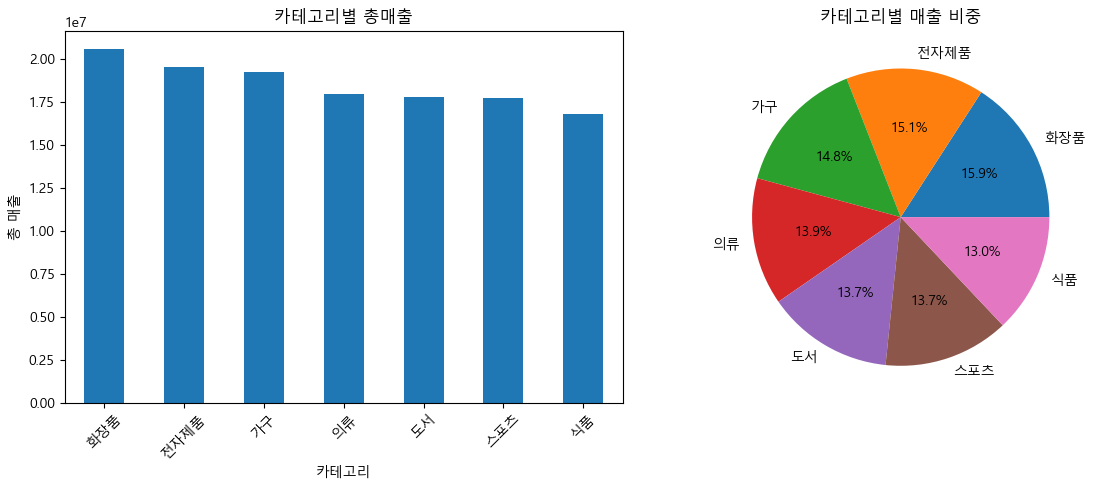

In [16]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 카테고리별 매출 비중 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_sum = df.groupby('카테고리')['매출액'].sum().sort_values(ascending=False)
category_sum.plot(kind='bar')
plt.title('카테고리별 총매출')
plt.ylabel('총 매출')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
category_sum.plot(kind='pie', autopct='%1.1f%%')
plt.title('카테고리별 매출 비중')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [17]:
# 월별 매출 트렌드
# '주문년월' 컬럼으로 매출액 sum, 주문ID count, 단가 mean
monthly_sales = df.groupby('주문년월').agg({
    '매출액': 'sum',
    '주문ID': ['count'],
    '단가': 'mean'
}).rename(columns={'주문ID': '주문건수'})

monthly_sales

,매출액,주문건수,단가
,sum,count,mean
주문년월,,,
2023-01,7786750,31,68573.324552
2023-02,13558838,47,83141.030344
2023-03,4820044,23,67224.537095
2023-04,13329098,49,97647.609208
2023-05,12825903,51,88883.442134
2023-06,10302473,44,64922.530177
2023-07,11575996,37,107918.450397
2023-08,11604378,47,69333.936651


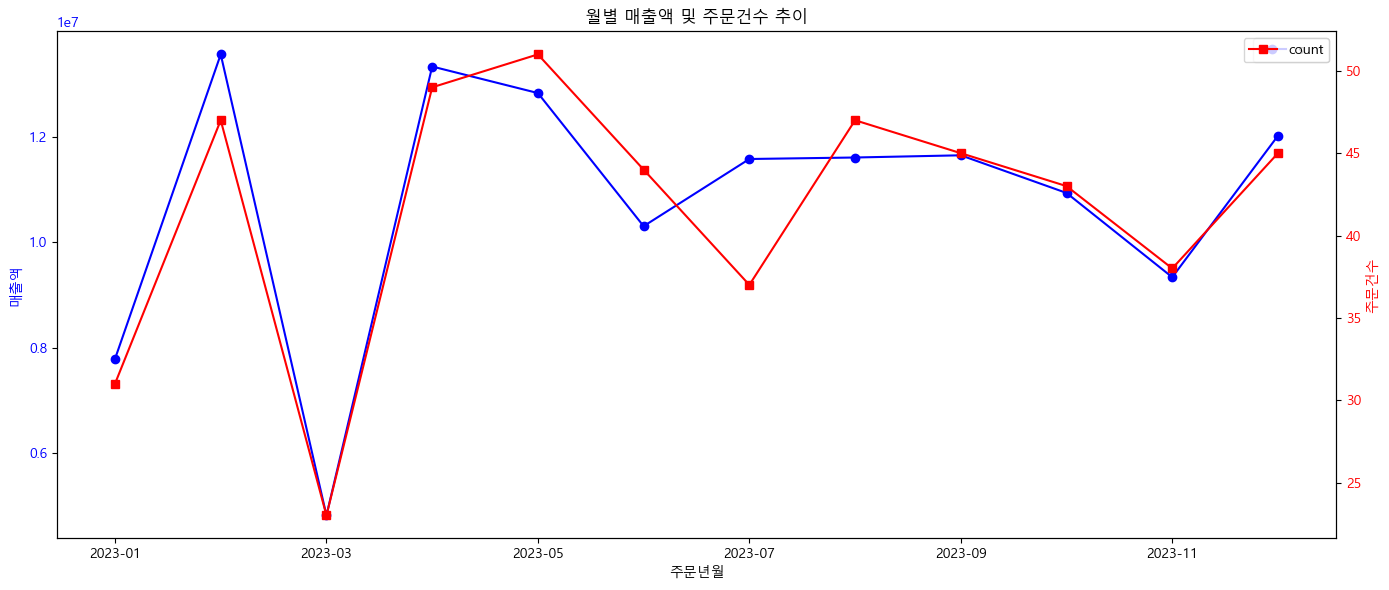

In [18]:
plt.figure(figsize=(14, 6))

# 매출액 추이
ax1 = plt.subplot(111)
monthly_sales['매출액'].plot(kind='line', marker='o', ax=ax1, color='blue')
ax1.set_title('월별 매출액 및 주문건수 추이')
ax1.set_ylabel('매출액', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 주문건수 추이 (보조 축)
ax2 = ax1.twinx()
monthly_sales['주문건수'].plot(kind='line', marker='s', ax=ax2, color='red')
ax2.set_ylabel('주문건수', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()


In [19]:
# 지역 & 카테고리별 매출 분석

# uunstack -> 다중인덱스 구조를 가로(열)로 펼쳐서 재구조화 함 : Index -> Col
regional_df = df.groupby(['지역', '카테고리'])['매출액'].sum().unstack()
regional_df

카테고리,가구,도서,스포츠,식품,의류,전자제품,화장품
지역,,,,,,,
강원,2567149,2229004,3236879,1546551,1961318,3064388,2350914
경기,1845589,1547956,2396558,2700479,3636189,2385742,3001775
광주,2583543,3290899,1543411,2609787,2337267,1158681,1920285
대구,2068333,1395664,1997663,1527438,2030142,2824580,2990911
대전,2806642,1400616,1817291,2557407,1321115,1665455,2186323
부산,1598356,1128322,1256823,749149,1827427,1714636,2565236
서울,2302258,2822680,2305854,1513749,2568012,1945582,1193348
울산,1396916,2365056,1497102,1385252,228601,1897187,2025993
인천,2094775,1646617,1677507,2226374,2061788,2870028,2365803


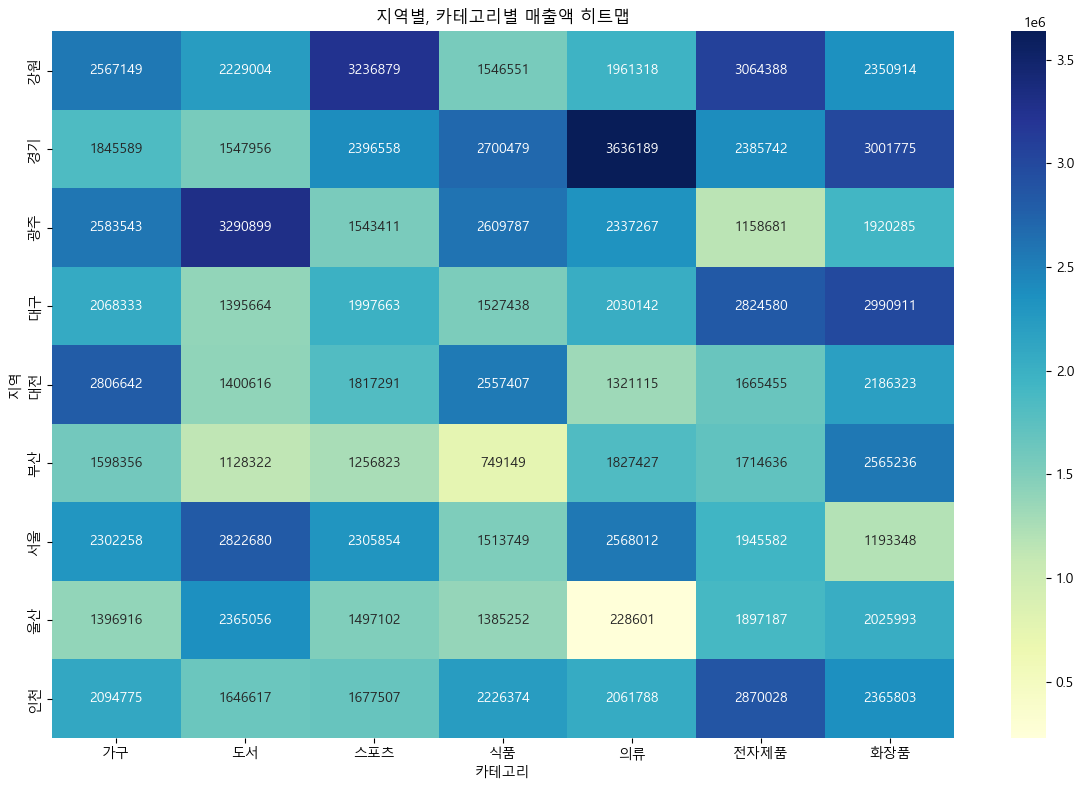

In [20]:
# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(regional_df, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('지역별, 카테고리별 매출액 히트맵')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_22280\259756578.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_grade_sales = df.groupby(['요일', '고객등급'])['매출액'].sum().unstack()


<Figure size 1400x700 with 0 Axes>

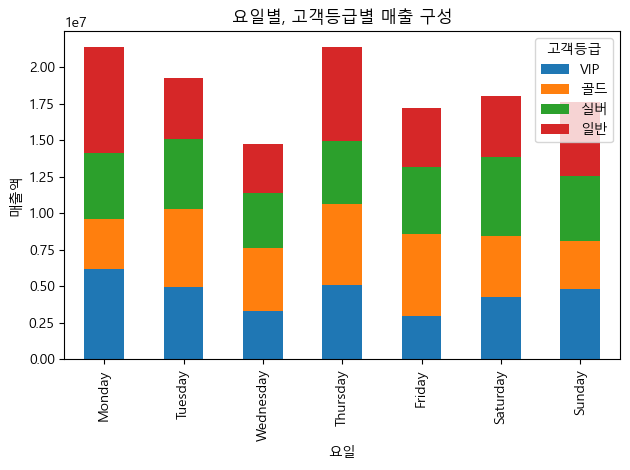

In [21]:
# 요일별 고객 등급별 매출 패턴

# 요일의 순서 지정
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['요일'] = pd.Categorical(df['요일'], categories=day_order, ordered=True)

day_grade_sales = df.groupby(['요일', '고객등급'])['매출액'].sum().unstack()

# 시각화
plt.figure(figsize=(14, 7))
day_grade_sales.plot(kind='bar', stacked=True)
plt.title('요일별, 고객등급별 매출 구성')
plt.ylabel('매출액')
plt.legend(title='고객등급')
plt.tight_layout()
plt.show()

In [22]:
# 결제방법별 분석 및 고객 행동 (매출액-sum mean count, 단가-mean)

total_sales = df['매출액'].sum()

def ratio(x):
    return x.sum() / total_sales * 100

payment_stats = df.groupby('결제방법').agg({
    '매출액': ['sum', 'mean', 'count', ratio],
    '단가': ['mean']
})

payment_stats

매출액                                            단가
           sum           mean count      ratio          mean
결제방법                                                        
계좌이체  26376866  251208.247619   105  20.331440  81029.835393
신용카드  25514730  260354.387755    98  19.666900  89773.784973
체크카드  26536652  260163.254902   102  20.454603  66063.697837
현금    25579043  272117.478723    94  19.716473  81782.442815
휴대폰   25727084  254723.603960   101  19.830584  84024.975216

In [23]:
# .nunique -> Series에서 고유한 값 개수 / DF 는 모든 컬럼에 고유한 값 개수

In [24]:
# 고객id 별 구매 패턴 (매출액 sum mean count, 구매한 고유 상품 수, 구매한 고유 카테고리 수)

def get_uniq_count(x):
    return x.nunique()

df.groupby('고객ID').agg({
    '매출액': ['sum', 'mean', 'count'],
    '상품ID': 'nunique',  # 위아래는 같다
    '카테고리': get_uniq_count,
}).sort_values([('매출액', 'sum'), ('상품ID', 'nunique')], ascending=False).head(3)

# sort_values(['a', 'b'])  => ORDER BY a, b => 단일 인덱스 컬럼
# sort_values([('a', 'sum'), ('b')])  => Col 'a', Agg 'sum' 값을 기준으로 정렬

매출액                         상품ID           카테고리
             sum           mean count nunique get_uniq_count
고객ID                                                        
CUST092  2814587  255871.545455    11      11              5
CUST017  2814138  281413.800000    10      10              6
CUST005  2709222  338652.750000     8       8              5

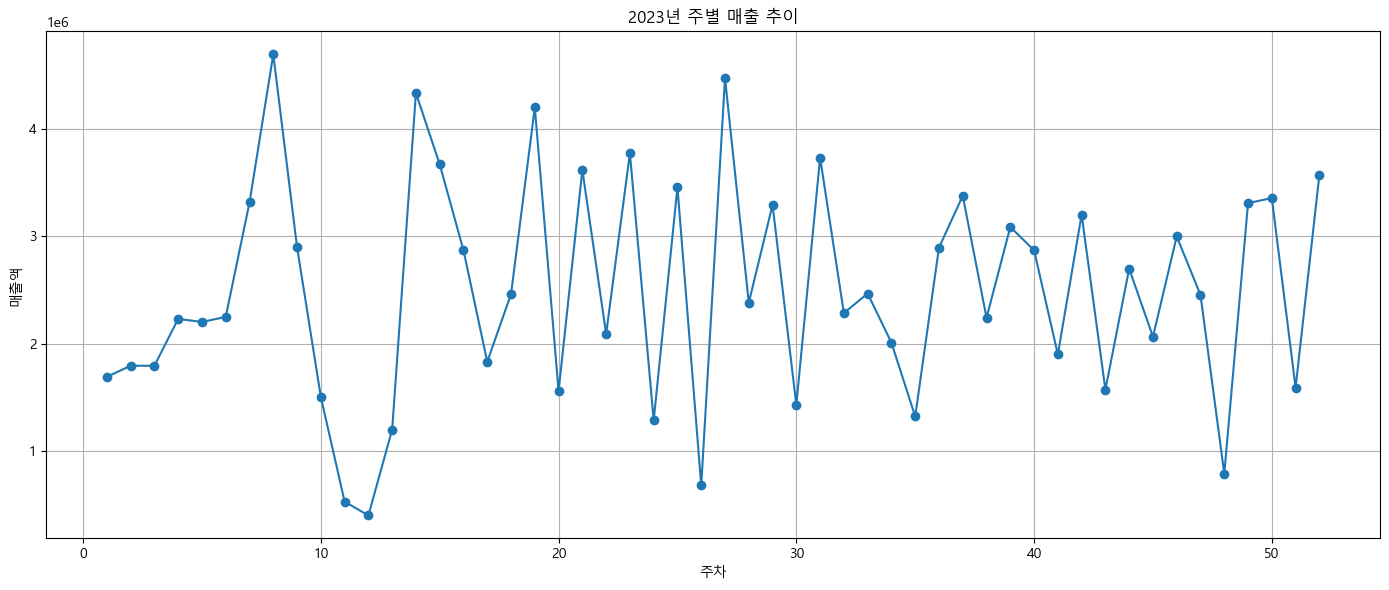

In [25]:
# 주별 매출 추이
weekly_sales = df.groupby('주')['매출액'].sum()

plt.figure(figsize=(14, 6))
weekly_sales.plot(kind='line', marker='o')
plt.title('2023년 주별 매출 추이')
plt.xlabel('주차')
plt.ylabel('매출액')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:

weekly_sales = df.groupby(['주문년월', '주'])['매출액'].sum().reset_index()
weekly_sales = weekly_sales.sort_values(['주문년월', '주'])

# .pct_change()는 바로 이전 행과의 비율 차이를 계산
# fillna(0)으로 첫 주의 결측치는 0으로 처리 (전주 없으니까 0으로)
weekly_sales['매출증감률'] = weekly_sales['매출액'].pct_change().fillna(0)

weekly_sales

,주문년월,주,매출액,매출증감률
0,2023-01,1,1693663,0.000000
1,2023-01,2,1796630,0.060795
2,2023-01,3,1796731,0.000056
3,2023-01,4,2232358,0.242455
4,2023-01,52,267368,-0.880231
5,2023-02,5,2203467,7.241327
6,2023-02,6,2250272,0.021242
7,2023-02,7,3313923,0.472677
8,2023-02,8,4689983,0.415236
9,2023-02,9,1101193,-0.765203


In [27]:
# 매출 TOP 10 상품

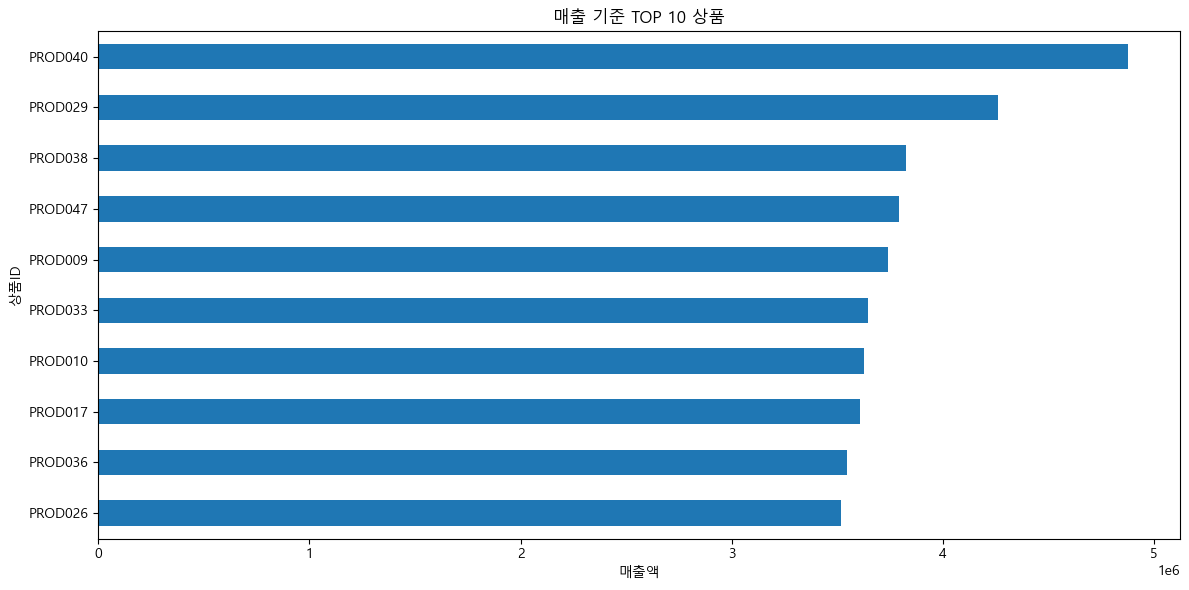

In [28]:
# 정렬 -> 위 10개
df.groupby('상품ID')['매출액'].sum().sort_values(ascending=False).head(10)

# 애초에 상위 10개만 가져와
top_products = df.groupby('상품ID')['매출액'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_products.sort_values().plot(kind='barh')
plt.title('매출 기준 TOP 10 상품')
plt.xlabel('매출액')
plt.tight_layout()
plt.show()

## 데이터 결합
1. 데이터 단순 결합(행 결합)
2. 데이터 병합
3. Index 기준 Join

In [29]:
# 데이터 결합 기초 (concat) - 행결합 (Col 똑같아야 함)

# 샘플 데이터 생성
# 첫 번째 데이터프레임: 1월 판매 데이터
df1 = pd.DataFrame({
    '상품ID': ['A001', 'A002', 'A003', 'A004', 'A005'],
    '상품명': ['노트북', '스마트폰', '태블릿', '헤드폰', '스피커'],
    '판매량_1월': [10, 20, 15, 30, 25]
})

# 두 번째 데이터프레임: 2월 판매 데이터
df2 = pd.DataFrame({
    '상품ID': ['A001', 'A003', 'A005', 'A006', 'A007'],
    '상품명': ['노트북', '태블릿', '스피커', '마우스', '키보드'],
    '판매량_2월': [12, 18, 23, 15, 19]
})

# 기본 concat - 행 결합 -> 안맞는 컬럼은 NaN
pd.concat([df1, df2])

# 인덱스 초기화 (겹치는 인덱스 없이 처음부터 다시)
pd.concat([df1, df2], ignore_index=True)

# 열 방향 결합
pd.concat([df1, df2], axis=1)

# join inner (공통 열만 유지)
pd.concat([df1, df2], join='inner')

,상품ID,상품명
0,A001,노트북
1,A002,스마트폰
2,A003,태블릿
3,A004,헤드폰
4,A005,스피커
0,A001,노트북
1,A003,태블릿
2,A005,스피커
3,A006,마우스
4,A007,키보드


In [30]:
# 데이터 병합 (merge)

products = pd.DataFrame({
    '상품ID': ['P001', 'P002', 'P003', 'P004', 'P005'],
    '상품명': ['노트북', '스마트폰', '태블릿', '헤드폰', '스피커'],
    '가격': [1200000, 850000, 500000, 150000, 75000],
    '카테고리': ['컴퓨터', '모바일', '모바일', '음향기기', '음향기기']
})

orders = pd.DataFrame({
    '주문번호': [1001, 1002, 1003, 1004, 1005, 1006],
    '고객ID': ['C001', 'C002', 'C003', 'C001', 'C004', 'C002'],
    '상품ID': ['P001', 'P002', 'P003', 'P002', 'P005', 'P006'],
    '수량': [1, 2, 1, 1, 3, 2],
    '주문일자': ['2023-01-05', '2023-01-10', '2023-01-15', '2023-01-20', '2023-01-25', '2023-01-30']
})


print(products)
print(orders)
# 기본 병합 (Inner Join)
pd.merge(orders, products, on='상품ID')

# Outer Join
pd.merge(orders, products, on='상품ID', how='outer')

# Left Join
pd.merge(orders, products, on='상품ID', how='left')

# Right Join
pd.merge(orders, products, on='상품ID', how='right')

   상품ID   상품명       가격  카테고리
0  P001   노트북  1200000   컴퓨터
1  P002  스마트폰   850000   모바일
2  P003   태블릿   500000   모바일
3  P004   헤드폰   150000  음향기기
4  P005   스피커    75000  음향기기
   주문번호  고객ID  상품ID  수량        주문일자
0  1001  C001  P001   1  2023-01-05
1  1002  C002  P002   2  2023-01-10
2  1003  C003  P003   1  2023-01-15
3  1004  C001  P002   1  2023-01-20
4  1005  C004  P005   3  2023-01-25
5  1006  C002  P006   2  2023-01-30


,주문번호,고객ID,상품ID,수량,주문일자,상품명,가격,카테고리
0,1001.0,C001,P001,1.0,2023-01-05,노트북,1200000,컴퓨터
1,1002.0,C002,P002,2.0,2023-01-10,스마트폰,850000,모바일
2,1004.0,C001,P002,1.0,2023-01-20,스마트폰,850000,모바일
3,1003.0,C003,P003,1.0,2023-01-15,태블릿,500000,모바일
4,NaN,NaN,P004,NaN,NaN,헤드폰,150000,음향기기
5,1005.0,C004,P005,3.0,2023-01-25,스피커,75000,음향기기


In [31]:
customers = pd.DataFrame({
    'ID': ['C001', 'C002', 'C003', 'C004', 'C005'],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민'],
    '등급': ['VIP', '골드', '실버', '골드', '브론즈']
})

# 열 이름이 다르면?
pd.merge(
    orders, 
    customers, 
    left_on='고객ID',  # orders 데이터프레임의 열 이름
    right_on='ID',    # customers 데이터프레임의 열 이름
    how='inner'
)

,주문번호,고객ID,상품ID,수량,주문일자,ID,이름,등급
0,1001,C001,P001,1,2023-01-05,C001,김철수,VIP
1,1002,C002,P002,2,2023-01-10,C002,이영희,골드
2,1003,C003,P003,1,2023-01-15,C003,박민수,실버
3,1004,C001,P002,1,2023-01-20,C001,김철수,VIP
4,1005,C004,P005,3,2023-01-25,C004,정지영,골드
5,1006,C002,P006,2,2023-01-30,C002,이영희,골드


In [32]:
import pandas as pd
import numpy as np

# 샘플 데이터셋 생성
# 1. 고객 정보 데이터
customers = pd.DataFrame({
    '고객ID': [f'CUST{i:03d}' for i in range(1, 11)],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민', '강준호', '윤서연', '임태혁', '한미래', '송지원'],
    '성별': ['남', '여', '남', '여', '남', '남', '여', '남', '여', '여'],
    '연령대': ['30대', '20대', '40대', '30대', '50대', '20대', '40대', '30대', '20대', '50대'],
    '가입일자': pd.date_range('2023-01-01', periods=10, freq='3D'),
    '지역': ['서울', '부산', '서울', '인천', '대구', '서울', '부산', '인천', '서울', '대구']
})

# 2. 주문 정보 데이터
np.random.seed(42)
n_orders = 50

orders = pd.DataFrame({
    '주문번호': [f'ORD{i:04d}' for i in range(1, n_orders+1)],
    '고객ID': np.random.choice(customers['고객ID'], n_orders),
    '주문일자': pd.date_range('2023-01-05', periods=n_orders, freq='2D'),
    '결제방법': np.random.choice(['신용카드', '체크카드', '계좌이체', '간편결제'], n_orders),
    '배송상태': np.random.choice(['배송완료', '배송중', '주문확인', '배송지연'], n_orders, p=[0.7, 0.15, 0.1, 0.05])
})

# 3. 주문 상세 정보 데이터
n_details = 80
products = ['노트북', '스마트폰', '태블릿', '헤드폰', '스피커', '키보드', '마우스', '모니터']
categories = ['전자제품', '컴퓨터', '주변기기', '음향기기']

order_details = pd.DataFrame({
    '상세번호': [f'ITEM{i:04d}' for i in range(1, n_details+1)],
    '주문번호': np.random.choice(orders['주문번호'], n_details),
    '상품명': np.random.choice(products, n_details),
    '카테고리': np.random.choice(categories, n_details),
    '수량': np.random.randint(1, 5, n_details),
    '가격': np.random.choice([50000, 100000, 150000, 800000, 1200000, 1500000], n_details),
    '할인율': np.random.choice([0, 0.1, 0.2, 0.3], n_details)
})

# 4. 배송 정보 데이터
shipping = pd.DataFrame({
    '주문번호': orders['주문번호'].unique(),
    '배송사': np.random.choice(['A택배', 'B물류', 'C익스프레스'], len(orders['주문번호'].unique())),
    '배송비': np.random.choice([0, 2500, 5000], len(orders['주문번호'].unique())),
    '출고일자': pd.date_range('2023-01-06', periods=len(orders['주문번호'].unique()), freq='2D')
})

# 5. 고객 만족도 데이터 (일부 주문에 대해서만)
satisfaction_orders = np.random.choice(orders['주문번호'], size=30, replace=False)
satisfaction = pd.DataFrame({
    '주문번호': satisfaction_orders,
    '만족도': np.random.randint(1, 6, 30),
    '리뷰': np.random.choice(['긍정', '중립', '부정'], 30, p=[0.6, 0.3, 0.1]),
    '리뷰일자': pd.date_range('2023-01-15', periods=30, freq='3D')
})


In [33]:
customers.head()

,고객ID,이름,성별,연령대,가입일자,지역
0,CUST001,김철수,남,30대,2023-01-01,서울
1,CUST002,이영희,여,20대,2023-01-04,부산
2,CUST003,박민수,남,40대,2023-01-07,서울
3,CUST004,정지영,여,30대,2023-01-10,인천
4,CUST005,최동민,남,50대,2023-01-13,대구


In [34]:
orders.head()

,주문번호,고객ID,주문일자,결제방법,배송상태
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중
1,ORD0002,CUST004,2023-01-07,계좌이체,배송완료
2,ORD0003,CUST008,2023-01-09,체크카드,배송지연
3,ORD0004,CUST005,2023-01-11,신용카드,배송중
4,ORD0005,CUST007,2023-01-13,간편결제,배송완료


In [35]:
order_details.head()

,상세번호,주문번호,상품명,카테고리,수량,가격,할인율
0,ITEM0001,ORD0044,마우스,음향기기,2,1200000,0.2
1,ITEM0002,ORD0020,헤드폰,전자제품,1,50000,0.1
2,ITEM0003,ORD0030,노트북,컴퓨터,2,1200000,0.1
3,ITEM0004,ORD0011,노트북,전자제품,3,800000,0.2
4,ITEM0005,ORD0028,모니터,음향기기,2,800000,0.1


In [36]:
shipping.head()

,주문번호,배송사,배송비,출고일자
0,ORD0001,A택배,2500,2023-01-06
1,ORD0002,C익스프레스,5000,2023-01-08
2,ORD0003,A택배,2500,2023-01-10
3,ORD0004,C익스프레스,5000,2023-01-12
4,ORD0005,B물류,2500,2023-01-14


In [37]:
satisfaction.head()

,주문번호,만족도,리뷰,리뷰일자
0,ORD0010,4,중립,2023-01-15
1,ORD0031,4,긍정,2023-01-18
2,ORD0002,5,부정,2023-01-21
3,ORD0024,2,중립,2023-01-24
4,ORD0032,4,긍정,2023-01-27


In [38]:
# 주문 - 주문상세  (합친다 - 테이블A, 테이블B)
pd.merge(orders, order_details, on='주문번호', how='inner').head()

,주문번호,고객ID,주문일자,결제방법,배송상태,상세번호,상품명,카테고리,수량,가격,할인율
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중,ITEM0009,모니터,음향기기,2,1500000,0.0
1,ORD0001,CUST007,2023-01-05,계좌이체,배송중,ITEM0047,헤드폰,음향기기,4,1200000,0.1
2,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,ITEM0033,키보드,전자제품,2,50000,0.0
3,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,ITEM0040,노트북,전자제품,2,50000,0.2
4,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,ITEM0041,노트북,음향기기,3,1200000,0.3


In [39]:
# 테이블A에 합친다 - 테이블B
orders.merge(order_details, on='주문번호', how='inner').head()

,주문번호,고객ID,주문일자,결제방법,배송상태,상세번호,상품명,카테고리,수량,가격,할인율
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중,ITEM0009,모니터,음향기기,2,1500000,0.0
1,ORD0001,CUST007,2023-01-05,계좌이체,배송중,ITEM0047,헤드폰,음향기기,4,1200000,0.1
2,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,ITEM0033,키보드,전자제품,2,50000,0.0
3,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,ITEM0040,노트북,전자제품,2,50000,0.2
4,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,ITEM0041,노트북,음향기기,3,1200000,0.3


In [40]:
# order_details 에서 총금액 -> group -> orders 에 총 주문금액 추가

# 1. 총 주문금액 계산 - 수량 * 가격 * (1-할인율)
total_series = order_details['수량'] * order_details['가격'] * (1 - order_details['할인율'])
order_details['총금액'] = total_series

# 2. 주문별 합계 계산 -> order_totals DF 생성
order_totals = order_details.groupby('주문번호')['총금액'].sum().reset_index()
order_totals

# 3. orders 와 order_totals 결합 -> 원래 없던 컬럼 추가
order_with_totals = orders.merge(order_totals, on='주문번호', how='left')

order_with_totals.head()

,주문번호,고객ID,주문일자,결제방법,배송상태,총금액
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중,7320000.0
1,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,3980000.0
2,ORD0003,CUST008,2023-01-09,체크카드,배송지연,6225000.0
3,ORD0004,CUST005,2023-01-11,신용카드,배송중,2520000.0
4,ORD0005,CUST007,2023-01-13,간편결제,배송완료,4050000.0


In [41]:
# 중복된 데이터들 모아서 보기
order_details[order_details.duplicated(subset=['주문번호'], keep=False)].sort_values('주문번호')

,상세번호,주문번호,상품명,카테고리,수량,가격,할인율,총금액
46,ITEM0047,ORD0001,헤드폰,음향기기,4,1200000,0.1,4320000.0
8,ITEM0009,ORD0001,모니터,음향기기,2,1500000,0.0,3000000.0
32,ITEM0033,ORD0002,키보드,전자제품,2,50000,0.0,100000.0
39,ITEM0040,ORD0002,노트북,전자제품,2,50000,0.2,80000.0
40,ITEM0041,ORD0002,노트북,음향기기,3,1200000,0.3,2520000.0
...,...,...,...,...,...,...,...,...
36,ITEM0037,ORD0049,모니터,주변기기,4,100000,0.0,400000.0
34,ITEM0035,ORD0049,스피커,전자제품,2,100000,0.2,160000.0
29,ITEM0030,ORD0049,스마트폰,주변기기,1,50000,0.0,50000.0
28,ITEM0029,ORD0049,노트북,음향기기,3,1500000,0.0,4500000.0


In [42]:
# 주문 데이터에 사용자 병합
orders_customers = order_with_totals.merge(customers, on='고객ID')
orders_customers.head()

,주문번호,고객ID,주문일자,결제방법,배송상태,총금액,이름,성별,연령대,가입일자,지역
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중,7320000.0,윤서연,여,40대,2023-01-19,부산
1,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,3980000.0,정지영,여,30대,2023-01-10,인천
2,ORD0003,CUST008,2023-01-09,체크카드,배송지연,6225000.0,임태혁,남,30대,2023-01-22,인천
3,ORD0004,CUST005,2023-01-11,신용카드,배송중,2520000.0,최동민,남,50대,2023-01-13,대구
4,ORD0005,CUST007,2023-01-13,간편결제,배송완료,4050000.0,윤서연,여,40대,2023-01-19,부산


In [43]:
# 배송정보 추가
full_orders = orders_customers.merge(shipping, on='주문번호')
full_orders.head()

# 배송 소요일 추가  (timedelta -> int)
full_orders['배송소요일'] = (full_orders['출고일자'] - full_orders['주문일자']).dt.days

full_orders

,주문번호,고객ID,주문일자,결제방법,배송상태,총금액,이름,성별,연령대,가입일자,지역,배송사,배송비,출고일자,배송소요일
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중,7320000.0,윤서연,여,40대,2023-01-19,부산,A택배,2500,2023-01-06,1
1,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,3980000.0,정지영,여,30대,2023-01-10,인천,C익스프레스,5000,2023-01-08,1
2,ORD0003,CUST008,2023-01-09,체크카드,배송지연,6225000.0,임태혁,남,30대,2023-01-22,인천,A택배,2500,2023-01-10,1
3,ORD0004,CUST005,2023-01-11,신용카드,배송중,2520000.0,최동민,남,50대,2023-01-13,대구,C익스프레스,5000,2023-01-12,1
4,ORD0005,CUST007,2023-01-13,간편결제,배송완료,4050000.0,윤서연,여,40대,2023-01-19,부산,B물류,2500,2023-01-14,1
5,ORD0006,CUST010,2023-01-15,체크카드,배송완료,11380000.0,송지원,여,50대,2023-01-28,대구,A택배,0,2023-01-16,1
6,ORD0007,CUST003,2023-01-17,간편결제,배송중,NaN,박민수,남,40대,2023-01-07,서울,C익스프레스,5000,2023-01-18,1
7,ORD0008,CUST007,2023-01-19,간편결제,배송중,180000.0,윤서연,여,40대,2023-01-19,부산,C익스프레스,5000,2023-01-20,1
8,ORD0009,CUST008,2023-01-21,체크카드,배송중,1290000.0,임태혁,남,30대,2023-01-22,인천,B물류,0,2023-01-22,1
9,ORD0010,CUST005,2023-01-23,체크카드,배송중,NaN,최동민,남,50대,2023-01-13,대구,A택배,5000,2023-01-24,1


In [44]:
# 만족도 정보 결합
with_satisfaction = full_orders.merge(satisfaction, on='주문번호', how='left')
with_satisfaction.head()

,주문번호,고객ID,주문일자,결제방법,배송상태,총금액,이름,성별,연령대,가입일자,지역,배송사,배송비,출고일자,배송소요일,만족도,리뷰,리뷰일자
0,ORD0001,CUST007,2023-01-05,계좌이체,배송중,7320000.0,윤서연,여,40대,2023-01-19,부산,A택배,2500,2023-01-06,1,NaN,NaN,NaT
1,ORD0002,CUST004,2023-01-07,계좌이체,배송완료,3980000.0,정지영,여,30대,2023-01-10,인천,C익스프레스,5000,2023-01-08,1,5.0,부정,2023-01-21
2,ORD0003,CUST008,2023-01-09,체크카드,배송지연,6225000.0,임태혁,남,30대,2023-01-22,인천,A택배,2500,2023-01-10,1,NaN,NaN,NaT
3,ORD0004,CUST005,2023-01-11,신용카드,배송중,2520000.0,최동민,남,50대,2023-01-13,대구,C익스프레스,5000,2023-01-12,1,4.0,중립,2023-03-16
4,ORD0005,CUST007,2023-01-13,간편결제,배송완료,4050000.0,윤서연,여,40대,2023-01-19,부산,B물류,2500,2023-01-14,1,5.0,부정,2023-03-19


In [45]:
# 분석: 연령대별, 성별 총 주문 금액
spending_stat = with_satisfaction.groupby(['연령대', '성별'])['총금액'].agg(
    ['sum', 'mean', 'count']
).reset_index()

spending_stat

,연령대,성별,sum,mean,count
0,20대,남,4550000.0,1.516667e+06,3
1,20대,여,26820000.0,3.352500e+06,8
2,30대,남,15555000.0,2.592500e+06,6
3,30대,여,16140000.0,4.035000e+06,4
4,40대,남,20675000.0,6.891667e+06,3
5,40대,여,27220000.0,4.536667e+06,6
6,50대,남,7270000.0,1.817500e+06,4
7,50대,여,18780000.0,6.260000e+06,3


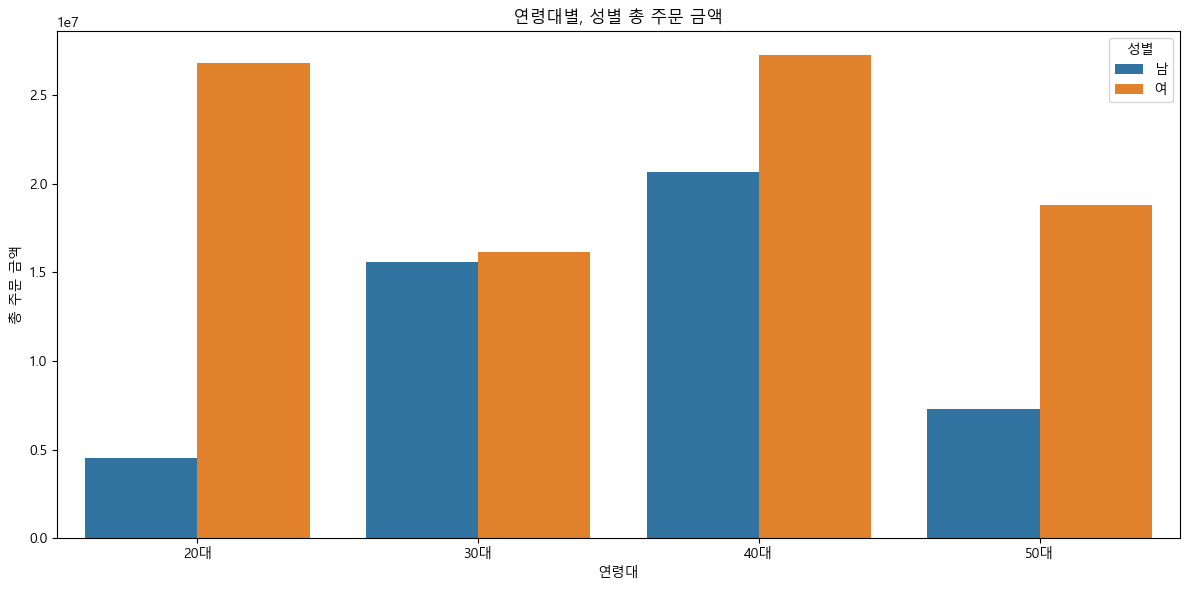

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
sns.barplot(x='연령대', y='sum', hue='성별', data=spending_stat)
plt.title('연령대별, 성별 총 주문 금액')
plt.ylabel('총 주문 금액')
plt.tight_layout()
plt.show()


In [47]:
# 분석: 결제방법별 평균 주문금액 및 건수
payment_analysis = with_satisfaction.groupby('결제방법').agg({
    '총금액': ['mean', 'sum', 'count']
}).reset_index()

payment_analysis

결제방법           총금액                  
                 mean         sum count
0  간편결제  3.911111e+06  35200000.0     9
1  계좌이체  3.934000e+06  19670000.0     5
2  신용카드  3.605000e+06  32445000.0     9
3  체크카드  3.549643e+06  49695000.0    14

In [48]:
# 만족도와 총 주문 금액 관계

# 결측치 제거
order_sati = with_satisfaction.dropna(subset=['만족도'])

# 만족도별 평균 주문 금액
sati_spend = order_sati.groupby('만족도')['총금액'].mean().reset_index()
sati_spend

,만족도,총금액
0,1.0,4.000000e+05
1,2.0,7.275000e+05
2,3.0,1.266667e+06
3,4.0,5.803333e+06
4,5.0,3.610000e+06


In [49]:
# 지역별 배송사 선호
# with_satisfaction.groupby(['지역', '배송사'])['주문번호'].count()  # 아래랑 결과 같음
region_shipping = with_satisfaction.groupby(['지역', '배송사']).size().unstack().fillna(0)
region_shipping

배송사,A택배,B물류,C익스프레스
지역,,,
대구,5.0,4.0,3.0
부산,7.0,1.0,4.0
서울,8.0,0.0,7.0
인천,4.0,3.0,4.0


<Figure size 1200x600 with 0 Axes>

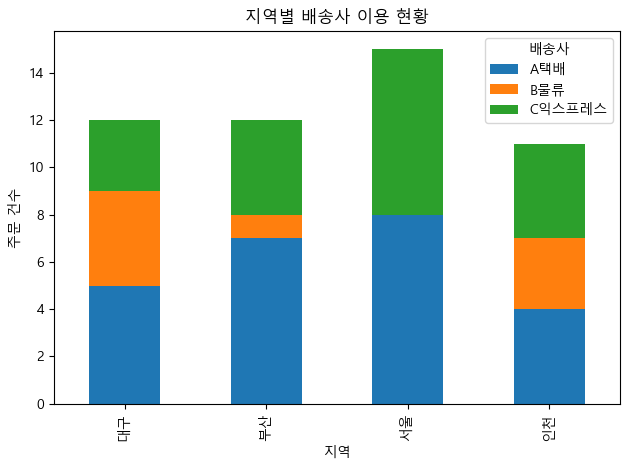

In [50]:
plt.figure(figsize=(12, 6))
region_shipping.plot(kind='bar', stacked=True)
plt.title('지역별 배송사 이용 현황')
plt.ylabel('주문 건수')
plt.legend(title='배송사')
plt.tight_layout()
plt.show()

## 이상치(Outlier) 처리
이상치의 정의
- Z-score
- IQR(4분위수)

In [51]:
# 샘플 데이터 생성: 온라인 쇼핑몰 주문 데이터
np.random.seed(42)
n = 1000

# 정상적인 데이터 생성
normal_prices = np.random.normal(50000, 15000, 900)  # 정상 가격대
normal_prices = np.round(normal_prices).astype(int)  # 정수 가격

normal_quantities = np.random.poisson(3, 900) + 1   # 정상 수량
normal_quantities = normal_quantities.astype(int)    # 정수 수량

# 이상치 데이터 추가
outlier_prices = np.random.uniform(200000, 500000, 100)  # 이상 고가 상품
outlier_prices = np.round(outlier_prices).astype(int)

outlier_quantities = np.random.uniform(50, 100, 100)      # 이상 대량 주문
outlier_quantities = np.round(outlier_quantities).astype(int)

# 전체 데이터 결합
prices = np.concatenate([normal_prices, outlier_prices])
quantities = np.concatenate([normal_quantities, outlier_quantities])

# DataFrame 생성
data = {
    '주문번호': [f'ORD{i:04d}' for i in range(1, n+1)],
    '가격': prices,
    '수량': quantities,
    '카테고리': np.random.choice(['전자제품', '의류', '가구', '식품', '도서'], n),
    '지역': np.random.choice(['서울', '부산', '인천', '대구', '광주'], n)
}

df = pd.DataFrame(data)
df['총금액'] = df['가격'] * df['수량']

df.head()

,주문번호,가격,수량,카테고리,지역,총금액
0,ORD0001,57451,5,가구,부산,287255
1,ORD0002,47926,5,식품,서울,239630
2,ORD0003,59715,4,식품,부산,238860
3,ORD0004,72845,7,도서,부산,509915
4,ORD0005,46488,3,식품,광주,139464


In [52]:
%pip install -q scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
# 1. Z-score(표준점수)

# 가격 기준 이상치 탐지
price_series = df['가격']
# Z-score 직접 계산
(price_series - price_series.mean()) / price_series.std()


def detect_outlier_zscore(data_series, threshold=3.0):
    from scipy import stats  # scipy 사용
    
    z_scores = stats.zscore(data_series)
    return np.abs(z_scores) > threshold  # [T, F, T, T] -> 이상한 데이터 True


# 이상치 데이터만 보기
price_outlier_z = detect_outlier_zscore(df['가격'], 3.0)

In [54]:
# 2. IQR(InterQuartile Range - 4분위) 방법
# price_series.describe()

def detect_outlier_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    return (data_series < lower_bound) | (data_series > upper_bound)


df[ detect_outlier_iqr(df['가격']) ]

,주문번호,가격,수량,카테고리,지역,총금액
209,ORD0210,107791,3,의류,서울,323373
262,ORD0263,1381,4,전자제품,대구,5524
900,ORD0901,498299,52,가구,서울,25911548
901,ORD0902,269819,59,전자제품,서울,15919321
902,ORD0903,216149,70,의류,광주,15130430
...,...,...,...,...,...,...
995,ORD0996,211943,88,식품,부산,18650984
996,ORD0997,282196,91,식품,서울,25679836
997,ORD0998,486695,67,식품,인천,32608565
998,ORD0999,486090,72,도서,광주,34998480


In [55]:
# 3. 백분위수 방법 (IQR과 달리 위/아래 이상치 직접 조정 가능)

def detect_outlier_perc(data_series, lower=1, upper=99):
    lower_bound = data_series.quantile(lower / 100)  # 하위 1%
    upper_bound = data_series.quantile(upper / 100)  # 상위 1%

    return (data_series < lower_bound) | (data_series > upper_bound)


odf = df[detect_outlier_perc(df['가격'], lower=1, upper=97)]
odf.count()

주문번호    40
가격      40
수량      40
카테고리    40
지역      40
총금액     40
dtype: int64

Text(0.5, 1.0, '수량 vs 가격')

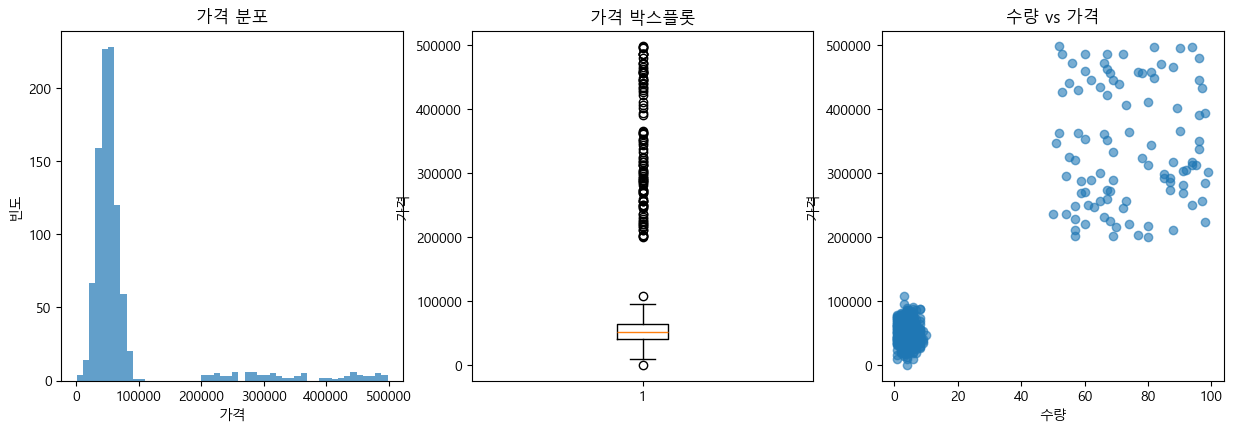

In [56]:
price_outliers_pct = detect_outlier_perc(df['가격'])
# 4. 다양한 방법 비교 시각화
plt.figure(figsize=(15, 10))

# 히스토그램
plt.subplot(2, 3, 1)
plt.hist(df['가격'], bins=50, alpha=0.7)
plt.title('가격 분포')
plt.xlabel('가격')
plt.ylabel('빈도')

# 박스플롯
plt.subplot(2, 3, 2)
plt.boxplot(df['가격'])
plt.title('가격 박스플롯')
plt.ylabel('가격')

# 산점도
plt.subplot(2, 3, 3)
plt.scatter(df['수량'], df['가격'], alpha=0.6)
plt.xlabel('수량')
plt.ylabel('가격')
plt.title('수량 vs 가격')

Text(0.5, 1.0, 'Z-score 이상치 (빨간색)')

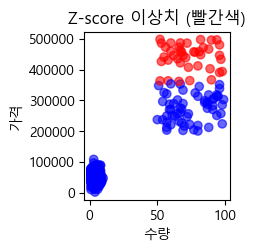

In [57]:
plt.subplot(2, 3, 4)
colors = ['red' if outlier else 'blue' for outlier in price_outlier_z]
plt.scatter(df['수량'], df['가격'], c=colors, alpha=0.6)
plt.xlabel('수량')
plt.ylabel('가격')
plt.title('Z-score 이상치 (빨간색)')

### 이상치 처리

In [58]:
df.head()

,주문번호,가격,수량,카테고리,지역,총금액
0,ORD0001,57451,5,가구,부산,287255
1,ORD0002,47926,5,식품,서울,239630
2,ORD0003,59715,4,식품,부산,238860
3,ORD0004,72845,7,도서,부산,509915
4,ORD0005,46488,3,식품,광주,139464


In [59]:
# data 에서 col 에 IQR기준 이상치를 삭제하는 함수
def remove_outliers_iqr(data: pd.DataFrame, col: str) -> pd.DataFrame:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    mask = (data[col] >= lower_bound) & (data[col] <= upper_bound)
    return data[mask]


df_removed = remove_outliers_iqr(df, '가격')
# 원본 길이, 정제 길이
print(len(df), len(df_removed))

1000 898


In [60]:
# 이상치 변환(Transform) 하기
# Winsorization (윈저화)  -> 이상치를 근처 값으로 바꾸기

def winsorize_outliers(data: pd.DataFrame, col, lower=5, upper=95):
    """윈저화: 극값을 특정 백분위 값으로 대체"""
    lower_bound = data[col].quantile(lower / 100)
    upper_bound = data[col].quantile(upper / 100)

    data_winsorized = data.copy()
    # clip: lower보다 작은 수를 다 인자로 바꾸고, upper보다 큰수도 모두 인자로 바꾼다.
    data_winsorized[col] = data_winsorized[col].clip(lower=lower_bound, upper=upper_bound)
    return data_winsorized

In [61]:
df_winsorized = winsorize_outliers(df, '가격', lower=10, upper=90)

In [62]:
# 이상치 대체(Imputation) 하기

# 중앙값 대체
def replace_outliers_with_median(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """IQR 이상치를 중앙값으로 대체"""
    data_replaced = data.copy()
    # IQR 이상처 탐지
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    # 중앙값
    med_val = data[col].median()
    outlier_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
    data_replaced.loc[outlier_mask, col] = int(med_val)

    return data_replaced

df_replaced = replace_outliers_with_median(df, '가격')
df_replaced['총금액'] = df_replaced['가격'] * df_replaced['수량']
df_replaced.tail()

,주문번호,가격,수량,카테고리,지역,총금액
995,ORD0996,52255,88,식품,부산,4598440
996,ORD0997,52255,91,식품,서울,4755205
997,ORD0998,52255,67,식품,인천,3501085
998,ORD0999,52255,72,도서,광주,3762360
999,ORD1000,52255,92,의류,부산,4807460


Text(0.5, 1.0, '원본 데이터')

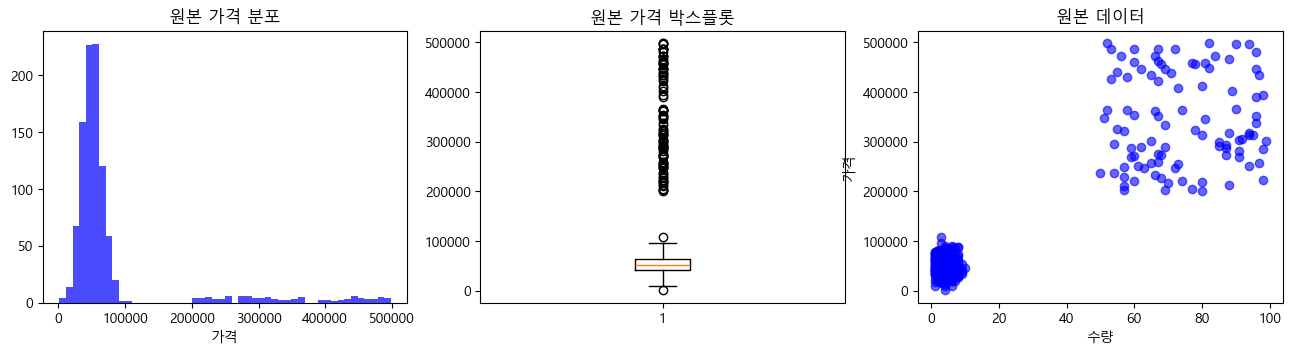

In [63]:
# 5. 처리 방법별 비교 시각화
plt.figure(figsize=(16, 12))

# 원본 데이터
plt.subplot(3, 3, 1)
plt.hist(df['가격'], bins=50, alpha=0.7, color='blue')
plt.title('원본 가격 분포')
plt.xlabel('가격')

plt.subplot(3, 3, 2)
plt.boxplot(df['가격'])
plt.title('원본 가격 박스플롯')

plt.subplot(3, 3, 3)
plt.scatter(df['수량'], df['가격'], alpha=0.6, color='blue')
plt.xlabel('수량')
plt.ylabel('가격')
plt.title('원본 데이터')

Text(0.5, 1.0, '제거 후')

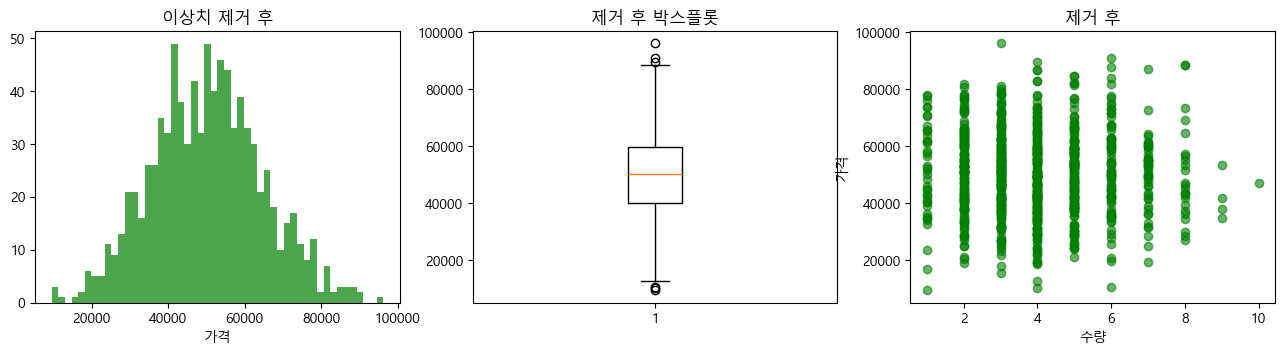

In [64]:
# 제거 후
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 4)
plt.hist(df_removed['가격'], bins=50, alpha=0.7, color='green')
plt.title('이상치 제거 후')
plt.xlabel('가격')

plt.subplot(3, 3, 5)
plt.boxplot(df_removed['가격'])
plt.title('제거 후 박스플롯')

plt.subplot(3, 3, 6)
plt.scatter(df_removed['수량'], df_removed['가격'], alpha=0.6, color='green')
plt.xlabel('수량')
plt.ylabel('가격')
plt.title('제거 후')

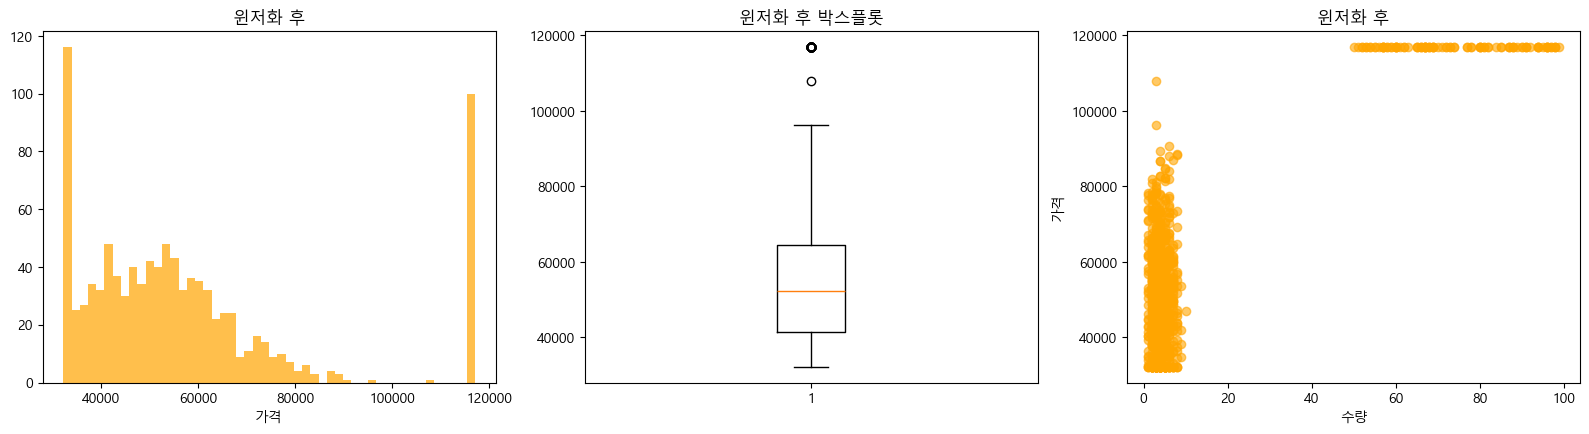

In [65]:
# Winsor 화
plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 7)
plt.hist(df_winsorized['가격'], bins=50, alpha=0.7, color='orange')
plt.title('윈저화 후')
plt.xlabel('가격')

plt.subplot(3, 3, 8)
plt.boxplot(df_winsorized['가격'])
plt.title('윈저화 후 박스플롯')

plt.subplot(3, 3, 9)
plt.scatter(df_winsorized['수량'], df_winsorized['가격'], alpha=0.6, color='orange')
plt.xlabel('수량')
plt.ylabel('가격')
plt.title('윈저화 후')

plt.tight_layout()
plt.show()

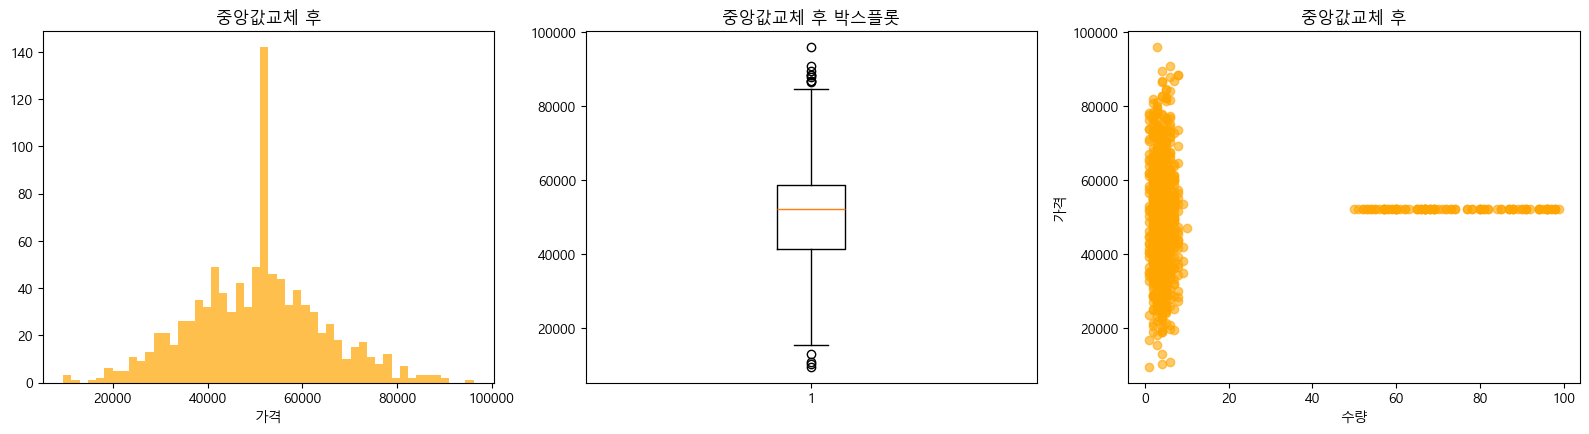

In [66]:
# Median 교체
plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 7)
plt.hist(df_replaced['가격'], bins=50, alpha=0.7, color='orange')
plt.title('중앙값교체 후')
plt.xlabel('가격')

plt.subplot(3, 3, 8)
plt.boxplot(df_replaced['가격'])
plt.title('중앙값교체 후 박스플롯')

plt.subplot(3, 3, 9)
plt.scatter(df_replaced['수량'], df_replaced['가격'], alpha=0.6, color='orange')
plt.xlabel('수량')
plt.ylabel('가격')
plt.title('중앙값교체 후')

plt.tight_layout()
plt.show()